# Background
You are working for an insurance company in Wakanda. The company provides
health and term life insurance products. The company has compiled the data of
5,500 insurees into the file insurance_data.csv, to understand whether they renew
their policies with the company or not. You can find the description of the data in the
table below.

# Task 1: You have to create a prediction model to understand insuree renewal behaviour.
Create a presentation/Jupyter notebook to highlight salient features of the data and model results.

# Guiding Questions
What is the data quality and which steps did you take to clean and structure the
dataset (e.g., how did you handle outliers, missing values, etc.)? <br/>
For validation purposes the company would like to see some typical cross sections
of the data. For example, think of the following:
1. What is the average number of riders health insurance customers purchase,
and which ones are the most popular?
2. What is the most popular rider for older people?
3. Which model did you use to gain insight into the insuree behaviour, and what
are the determining factors for choosing this model?
4. Why are the insurees not renewing and what are the most important factors?

# Assumptions
1. Commas are replaced by decimal points for monthlyPremium and totalPremium as they are supposed to be of type float.
2. 'no term life policy taken' and 'term life policy not taken' means insuree has no term life insurance
3. NA values will be replaced with integer 0 for healthRiders, assuming insurees left it blank because they have no riders on their health policies.


### Import libraries and dataset
---

In [12]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
#Import dataset
df = pd.read_csv("insurance_data.csv", delimiter=';')

## Data Wrangling
---

### Data Cleaning - Preliminary check of data type and content of each column

In [14]:
#Preliminary check of each column's data type and values
for col in df.columns:
    print(df[col].dtype, col, df[col].sort_values().unique()[:10])

int64 insuree# [ 1  2  3  4  5  6  7  8  9 10]
object gender ['F' 'M' nan]
float64 is45OrOlder [ 0.  1. nan]
object isMarried ['No' 'Yes']
object hasKids ['No' 'Yes']
int64 insuredMonths [0 1 2 3 4 5 6 7 8 9]
object termLifeInsurance ['No' 'Yes']
object multipleTermLifePolicies ['No' 'Yes' 'no term life policy taken' 'term life policy not taken']
object healthInsurance ['Class A' 'Class B' 'No']
object healthRiders ['1' '1,2' '1,2,3' '1,2,3,4' '1,2,4' '1,3' '1,3,4' '1,4' '2' '2,3']
float64 premiumFrequency [ 1.  3. 12. nan]
object eStatements ['No' 'Yes']
object monthlyPremium ['100' '100,05' '100,1' '100,15' '100,2' '100,25' '100,3' '100,35' '100,4'
 '100,45']
object totalPremium [' ' '100,2' '100,25' '100,35' '100,8' '100,9' '1001,2' '1001,5' '1004,35'
 '1004,5']
object renewal ['N' 'Y']


### Data Cleaning - Fix content of each column

In [15]:
#Fix multipleTermLifePolicies column - Only Yes or No
df['multipleTermLifePolicies'] = df['multipleTermLifePolicies'].replace(['no term life policy taken', 'term life policy not taken'], 'No')

#Fix healthInsurance column - Only Yes or No
df['healthInsurance'] = df['healthInsurance'].replace(['Class A', 'Class B'], 'Yes')

#Fix monthlyPremium, totalPremium - comma replaced by decimal point for float type
df['monthlyPremium'] = df['monthlyPremium'].str.replace(',', '.')
df['totalPremium'] = df['totalPremium'].str.replace(',', '.')

#Fix totalPremium - remove empty string
df.loc[df.totalPremium == ' ', 'totalPremium'].count() #small number (9) of rows with empty string
df['totalPremium'] = df['totalPremium'].replace(' ', np.nan)
df.dropna(subset=['totalPremium'], inplace=True)

#Fix renewal - change Y, N to Yes, No for standardization
df['renewal'] = df['renewal'].replace({'Y':'Yes', 'N':'No'})

### Data Cleaning - NAs

#### Steps taken to treat NA values:
1. Find columns with NA values
2. If number of NA values is insignificant, will remove rows with NA values - removal of rows won't affect result much
3. If number of NA values is significant, will replace with a proper value based on context of question

#### Results:
1. NA values will be removed for columns: gender, is45OrOlder, premiumFrequency because total % of NA removed is only 5.87% (insignificant). Therefore, sufficient data is still available for training prediction model
2. NA values will be replaced with integer 0 for column: healthRiders. Since the amount of missing values are too significant, it can be assumed that the missing values are intentional - maybe due to some miscommunication when insurees were asked to answer the questions. Hence, it is possible that insurees did not fill in the data for healthRiders because they have zero riders on their health plans and intentionally left it blank.

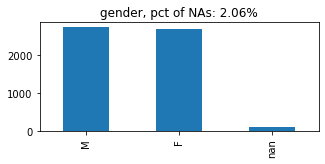

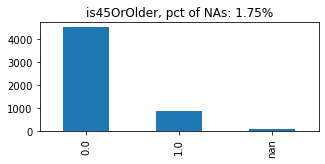

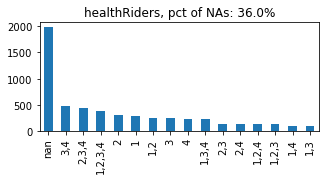

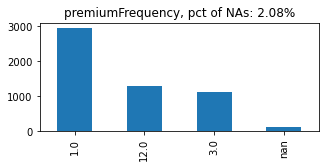

In [16]:
#Check NA values for each columns - has problems: gender, is45OrOlder, healthRiders, premiumFrequency
df.isna().sum()

#Preliminary data exploration to check each NA columns individually
for col in df.columns[df.isna().any()].tolist():
    count_NA = df[col].isna().sum()
    pct_NA = round(count_NA*100/df.shape[0],2)
    fig = plt.figure(figsize=(5,2))
    df[col].value_counts(dropna=False).plot(kind='bar', title=f'{col}, pct of NAs: {pct_NA}%')

In [17]:
#Treat NA values

#Remove NA values for gender, is45OrOlder, premiumFrequency - total rows removed is only ~6% of dataset
df.dropna(subset=['gender', 'is45OrOlder', 'premiumFrequency'], inplace=True)

#Replace NA values with 0 for healthRiders - assume NA values are actually 0
df['healthRiders'].fillna(0, inplace=True)

#Final check
df.isna().sum()

insuree#                    0
gender                      0
is45OrOlder                 0
isMarried                   0
hasKids                     0
insuredMonths               0
termLifeInsurance           0
multipleTermLifePolicies    0
healthInsurance             0
healthRiders                0
premiumFrequency            0
eStatements                 0
monthlyPremium              0
totalPremium                0
renewal                     0
dtype: int64

### Data Cleaning - Correcting data types of each column


In [18]:
#Convert to correct data type based on context
convert_dict = {
    'insuree#' : 'int64',
    'gender': str,
    'is45OrOlder': 'category',
    'isMarried':'category',
    'hasKids': str,
    'insuredMonths': 'int64',
    'termLifeInsurance': 'category',
    'multipleTermLifePolicies': 'category',
    'healthInsurance': 'category',
    'healthRiders': str,
    'premiumFrequency': 'int64',
    'eStatements': 'category',
    'monthlyPremium': 'float64',
    'totalPremium': 'float64',
    'renewal': 'category',
}

df = df.astype(convert_dict)
df.dtypes

insuree#                       int64
gender                        object
is45OrOlder                 category
isMarried                   category
hasKids                       object
insuredMonths                  int64
termLifeInsurance           category
multipleTermLifePolicies    category
healthInsurance             category
healthRiders                  object
premiumFrequency               int64
eStatements                 category
monthlyPremium               float64
totalPremium                 float64
renewal                     category
dtype: object

### Data Cleaning - Outliers

#### Steps taken to treat outlier values:
1. Check outliers for columns with int/float data types
2. Use interquartile range rule to remove outliers

#### Results:
1. 5096 rows remain after removal (93% data retained) - still sufficient for training model

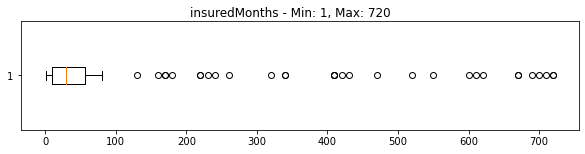

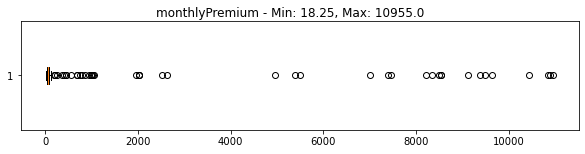

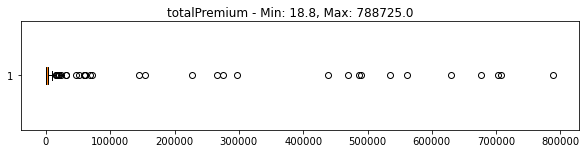

In [19]:
#Check outlier using boxplot for each int/float column:
for col in ['insuredMonths', 'monthlyPremium', 'totalPremium']:
    val_min, val_max = df[col].min(), df[col].max()
    fig = plt.figure(figsize=(10,2))
    plt.boxplot(df[col], vert=False)
    fig.suptitle(f'{col} - Min: {val_min}, Max: {val_max}')

(5096, 15)


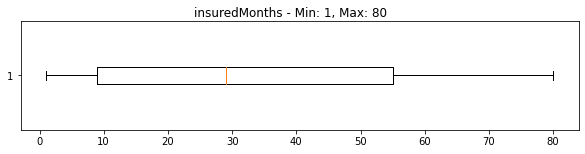

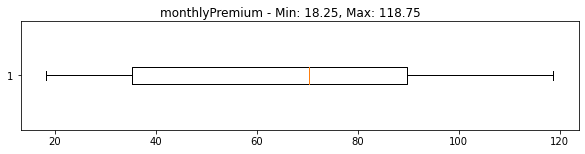

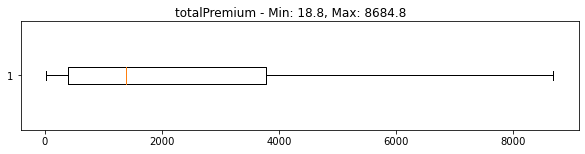

In [40]:
#Treat outliers using interquartile range
df_no_outlier = df.copy()
index_list = []
for col in ['insuredMonths', 'monthlyPremium', 'totalPremium']:
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    upper_limit = df[col].quantile(0.75) + 1.5*IQR
    lower_limit = df[col].quantile(0.75) - 1.5*IQR
    df_no_outlier = df_no_outlier.loc[(df[col] >= lower_limit) & (df[col] <= upper_limit)]

#Final check for outliers
print(df_no_outlier.shape) #~7% data removed from orginal dataset
for col in ['insuredMonths', 'monthlyPremium', 'totalPremium']:
    val_min, val_max = df_no_outlier[col].min(), df_no_outlier[col].max()
    fig = plt.figure(figsize=(10,2))
    plt.boxplot(df_no_outlier[col], vert=False)
    fig.suptitle(f'{col} - Min: {val_min}, Max: {val_max}')
